In [ ]:
!pip install gymnasium
import random
from copy import deepcopy
import gymnasium
import numpy as np
from typing import Tuple, List, Optional
import matplotlib.pyplot as plt

GYM_STRING = "Taxi-v3"
TERMINAL_REWARDS = [20]


class QLearningSolver:
    """
    Class containing the Q-learning algorithm that might be used for different discrete environments.
    State/action np.ndarray needs to have ndim <= 1 (1 element) or be ints.
    """

    def __init__(self, observation_space: int, action_space: int, learning_rate: float = 0.1, gamma: float = 0.9,
                 epsilon: float = 0.1, terminal_rewards: list[float] = None):
        self.observation_space = observation_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.terminal_rewards = [] if terminal_rewards is None else deepcopy(terminal_rewards)
        self.q_dict = dict()
        for i in range(self.observation_space):
            self.q_dict[i] = [float(0) for _ in range(self.action_space)]

    @staticmethod
    def resolve(array: np.ndarray | int) -> int:
        if type(array) is int:
            return array
        if array.ndim == 0:
            return int(array)
        return array[0]

    def __call__(self, state: np.ndarray | int, action: np.ndarray | int) -> np.ndarray:
        """Return Q-value of given state and action."""
        value = self.q_dict[self.resolve(state)][self.resolve(action)]
        return np.array(value)

    def update(self, state: np.ndarray | int, action: np.ndarray | int, result_state: np.ndarray | int, reward: float)\
            -> None:
        """Update Q-value of given state and action."""
        before = self.resolve(state)
        option = self.resolve(action)
        after = self.resolve(result_state)
        if reward in self.terminal_rewards:
            self.q_dict[before][option] = reward  # terminal state found
        else:
            self.q_dict[before][option] = ((1 - self.learning_rate) * self.q_dict[before][option]
                                           + self.learning_rate * (reward + self.gamma * max(self.q_dict[after])))

    def get_action(self, state: np.ndarray | int) -> np.ndarray:
        """Return action with epsilon chance to be a random one and 1 - epsilon to be optimal."""
        if random.random() < self.epsilon:
            return np.array([random.randrange(0, self.action_space)])
        return self.get_best_action(state)

    def get_best_action(self, state: np.ndarray | int) -> np.ndarray:
        """Return action that maximizes Q-value for a given state."""
        options = self.q_dict[self.resolve(state)]
        best_action = 0
        best_value = options[0]
        for i in range(len(options)):
            if options[i] > best_value:
                best_action = i
                best_value = options[i]
        return np.array(best_action)

    def __repr__(self):
        """Elegant representation of Q-learning solver."""
        result = f"QLearningSolver - observation space: {self.observation_space}, action space: {self.action_space}\n"
        result += f"Learning rate: {self.learning_rate}, gamma: {self.gamma}, epsilon: {self.epsilon}\n"
        result += f"Terminal rewards: {self.terminal_rewards}, Q table:\n\n"
        for i in range(self.observation_space):
            result += f"{i}: {self.q_dict[i]}\n"
        return result + "\n\n\n"

    def __str__(self):
        return self.__repr__()

Implementacja klasy do Q-learningu, która przechowuje tablicę Q-wartości i analizuje nagrody za zaproponowane akcje. Będzie wykorzystywana w trenowaniu AI do przewozu pasażerów taksówką w programie z gymnasium.

Funkcja, która trenuje model i testuje go po wykonanym odcinku:

In [ ]:
def training_episode(env: gymnasium.Env, state: np.ndarray | int, solver: QLearningSolver, steps_per_episode: int,
                     tests: int) -> Tuple[np.ndarray | int, float]:
    """Trains the solver for the specified amount of steps and tests its current quality after finishing."""
    new_observation = state
    for _ in range(steps_per_episode):
        observation = new_observation
        action = QLearningSolver.resolve(solver.get_action(observation))
        new_observation, reward, terminated, truncated, _ = env.step(action)
        solver.update(observation, action, new_observation, float(reward))
        if terminated or truncated:
            new_observation, _ = env.reset()

    test_env = gymnasium.make(GYM_STRING)
    total_reward = 0
    for _ in range(tests):
        observation, _ = test_env.reset()
        terminated = False
        truncated = False
        while not terminated and not truncated:
            action = QLearningSolver.resolve(solver.get_best_action(observation))
            observation, reward, terminated, truncated, _ = test_env.step(action)
            total_reward += reward
    test_env.close()

    return new_observation, total_reward / tests

Funkcje, za pomocą których można sprawdzić, jak przebiega trening modelu o zadanych parametrach:

In [ ]:
def benchmark(gamma: float, epsilon: float, episodes: int = 900, steps_per_episode: int = 1000, tests: int = 10,
              learning_rates: Optional[List[float]] = None, show_plot=True) -> Optional[List[List[float]]]:
    """Tests how QLearningSolver works - trains it with various learning rates and returns or plots the progress."""
    learning_rates = [0.1, 0.5, 0.9] if learning_rates is None else learning_rates
    results = [[] for _ in range(len(learning_rates))]

    for i in range(len(learning_rates)):
        env = gymnasium.make(GYM_STRING)
        solver = QLearningSolver(env.observation_space.n, env.action_space.n,
                                 learning_rates[i], gamma, epsilon, TERMINAL_REWARDS)
        state, _ = env.reset()
        for _ in range(episodes):
            state, reward = training_episode(env, state, solver, steps_per_episode, tests)
            results[i].append(reward)
        env.close()

    if not show_plot:
        return results
    return plot(results, episodes, steps_per_episode, gamma, epsilon, learning_rates)


def plot(data: List[List[float]], episodes: int, steps_per_episode: int, gamma: float, epsilon: float,
         learning_rates: List[float]) -> None:
    """Plots the progress history of QLearningSolver training. Can work with many lists."""
    fig, ax = plt.subplots()
    x_axis = [x * steps_per_episode for x in range(episodes)]
    for i in range(len(data)):
        ax.plot(x_axis, data[i], label=f'Learning rate {learning_rates[i]}')
    ax.legend()
    plt.title(f"Progress of Q-learning with gamma {gamma} and epsilon {epsilon} - average reward after x steps")
    plt.show()

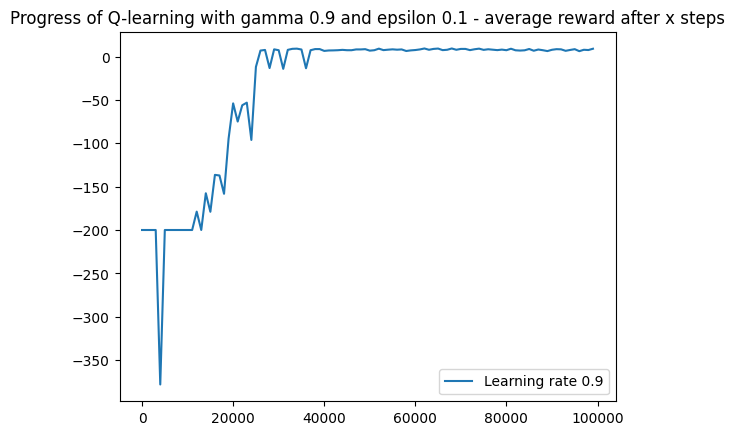

QLearningSolver - observation space: 500, action space: 6
Learning rate: 0.9, gamma: 0.9, epsilon: 0.1
Terminal rewards: [20], Q table:

0: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1: [-0.5861996015438727, 0.4603532029405897, -0.585682117558855, 0.46035320239267674, 1.6226146700000021, -8.539646797000206]
2: [4.348906134051789, 5.943229897354628, 4.348906999852791, 5.943229999897357, 7.714700000000002, -3.0567759432299972]
3: [0.46035320299994137, 1.6226139820291747, 0.4547244243467762, 1.6226146699926842, 2.9140163000000023, -7.377385330162259]
4: [-7.066420946993469, -7.329580488727939, -4.9968454901000285, -7.329580488727939, -13.6898665484679, -14.308283164135005]
5: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
6: [-4.9968454901000285, -7.355991231147113, -7.126735736900673, -7.329580488727939, -13.947446184194318, -14.845852737237296]
7: [-3.1369622635116983, -4.086570765956998, -6.417763777032103, -4.087805587602016, -9.0, -12.994489167666202]
8: [1.6226146700000021, -6.105838818818925, -1.1154586549363

In [ ]:
results = []
env = gymnasium.make(GYM_STRING)
solver = QLearningSolver(env.observation_space.n, env.action_space.n, 0.9, 0.9, 0.1, TERMINAL_REWARDS)
state, _ = env.reset()
for _ in range(100):
    state, reward = training_episode(env, state, solver, 1000, 10)
    results.append(reward)
env.close()

plot([results], 100, 1000, 0.9, 0.1, [0.9])
print(solver)

Wykres ukazuje postępy w trenowaniu modelu po n wykonanych krokach. Wykonywane jest 10 testów, w których plansza jest resetowana i model próbuje wykonać zadanie. Wynik spada o ~200, gdy w którymś teście program utknął na niepoprawnej operacji z pasażerem, a o ~20, gdy nie zdołał go zawieźć na miejsce przed przerwaniem testu. Model bardzo szybko oducza się zabierać i odstawiać pasażera w niewłaściwym momencie, a z czasem udaje mu się wykonywać zadanie i wynik oscyluje w okolicach 8 punktów, co widać na zbliżeniach wykresu poniżej.

Print spod wykresu pokazuje zawartość tablicy Q-wartości - zerowe pozycje to nieosiągalne stany programu.

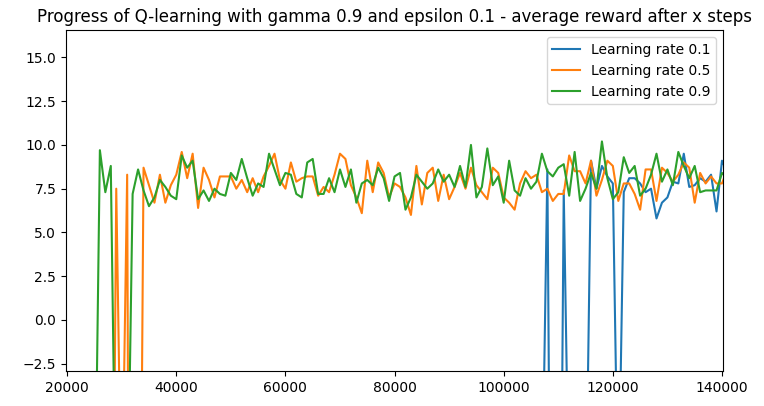

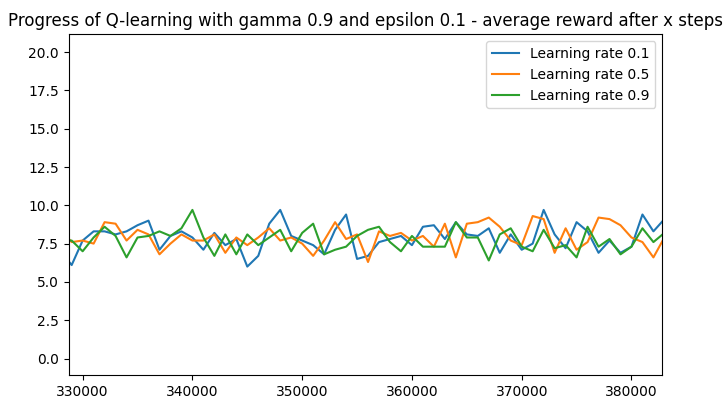

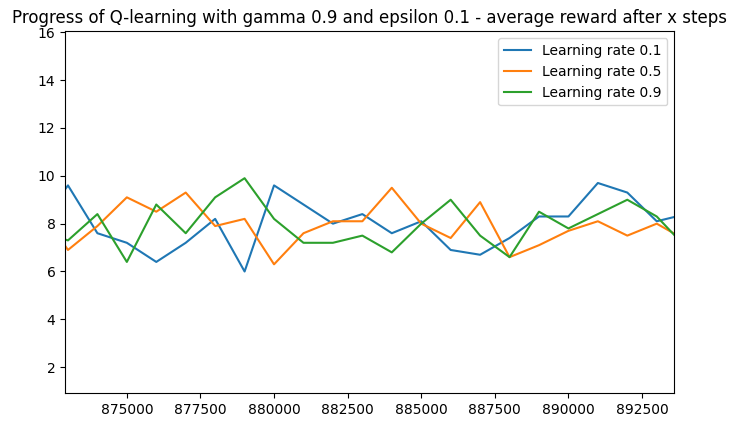

Eksperymenty z różnymi wartościami parametrów. Z wykresów wynika, że uczenie osiąga zamierzone rezultaty najszybciej, gdy parametry learning rate i gamma są bliskie 1, a epsilon jest bliski 0. Skłania to model do większych zmian w tabeli, dużej eksploatacji i skupieniu się na przyszłej nagrodzie, co dobrze pasuje do specyfiki tego zadania - to samo działanie daje ten sam efekt, nagrodę daje tylko szybkie zawiezienie pasażera na miejsce, a optymalizacja  działającego, ale wolnego rozwiązania nie jest bardzo skomplikowana (będzie wystarczyła zmiana kierunku jazdy w kilku miejscach, by skrócić trasę). Ostatecznie jednak przy każdych parametrach model dąży do optymalnego zachowania.

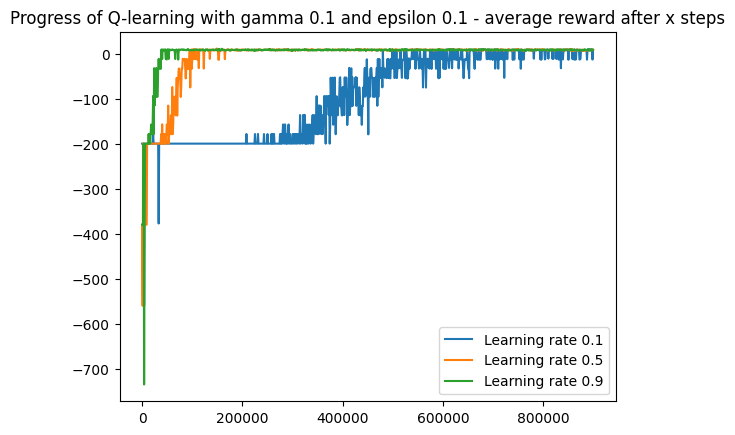

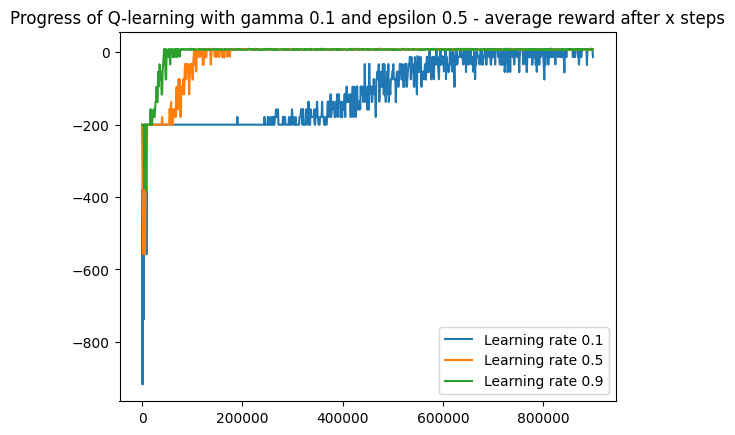

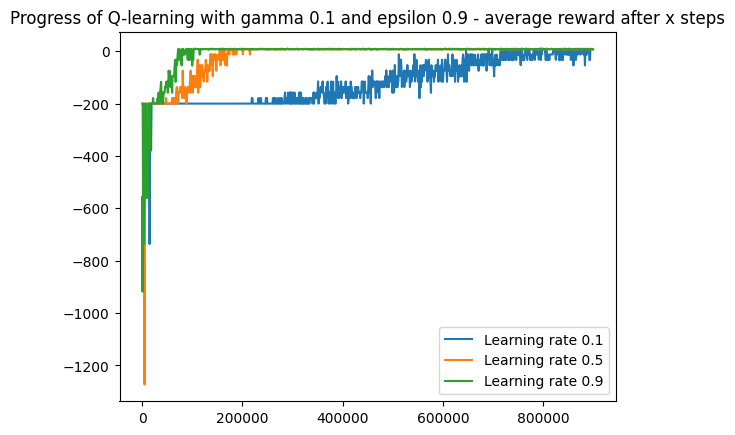

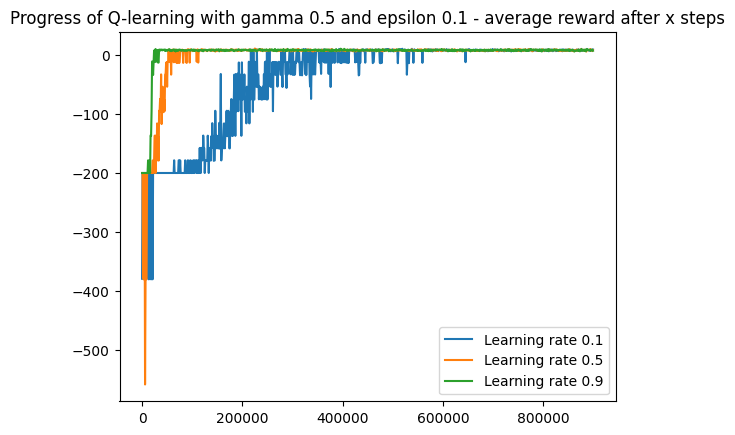

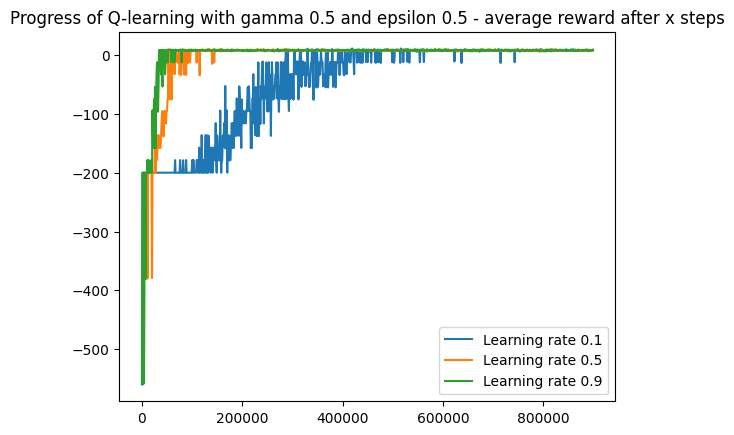

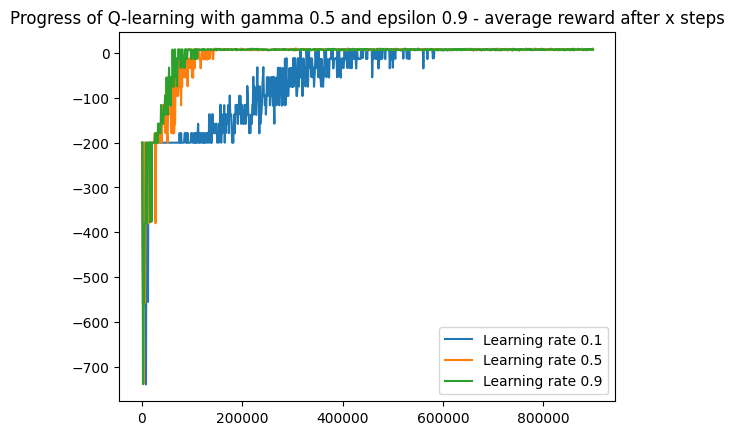

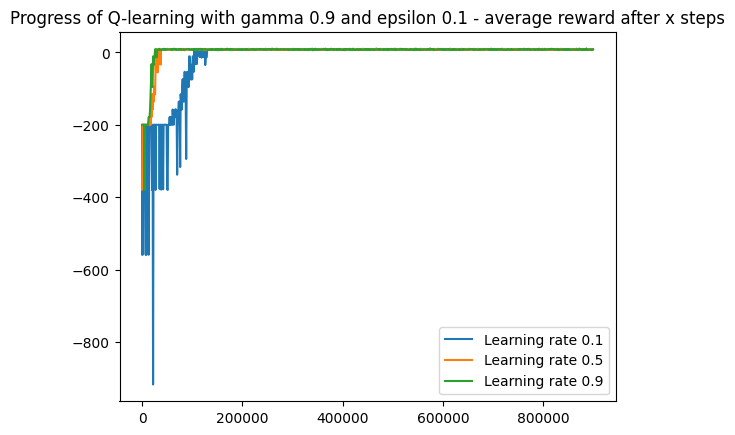

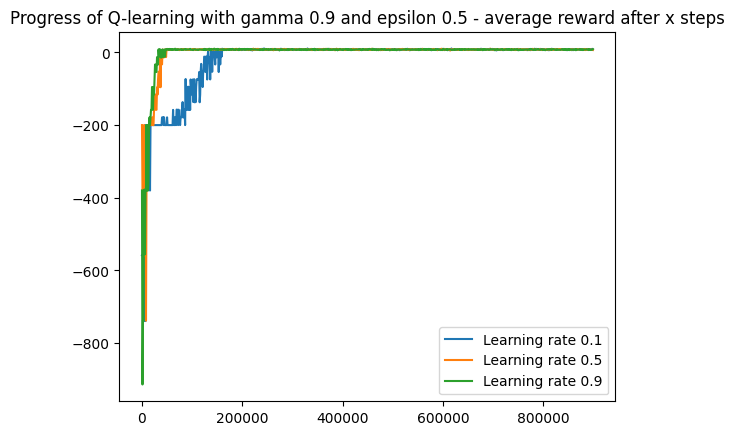

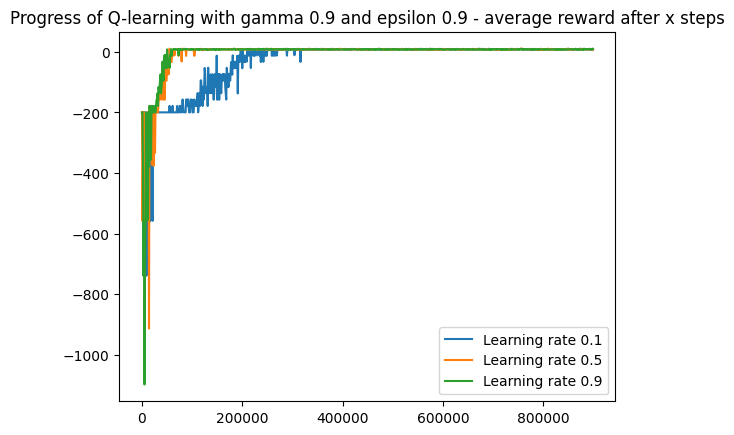

In [ ]:
for gamma in [0.1, 0.5, 0.9]:
    for epsilon in [0.1, 0.5, 0.9]:
        benchmark(gamma, epsilon)